# Ancient Myths Text Generator

This notebook demonstrates how to build a text generation model using LSTM networks with TensorFlow/Keras on a unique dataset: *Ancient Myths: A Collection of Global Legends*. The notebook includes data preprocessing, model building, training, text generation, and an experiment on the effect of increasing network layers on generated text coherence.

In [2]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed
import matplotlib.pyplot as plt

# Use a color-blind-friendly style for plots
plt.style.use('tableau-colorblind10')

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2025-03-25 22:29:38.397721: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-25 22:29:38.557333: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-25 22:29:38.652676: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742941778.772457    1618 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742941778.805820    1618 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742941779.061033    1618 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

## Data Preprocessing

We begin by creating a simple text corpus from the unique dataset *Ancient Myths: A Collection of Global Legends*. In a real scenario, load your data from a file or URL.

In [3]:
# Sample corpus from 'Ancient Myths: A Collection of Global Legends'
text_corpus = """
In the ancient lands of Eldoria, where legends whispered through the winds,
the gods and mortals intertwined their fates. Tales of valor and magic danced in the twilight.
Mystical creatures roamed the enchanted forests, and secret lore was passed down through generations.
In every corner, a story waited to be told...
"""

# Preprocess the text
text = text_corpus.lower()
chars = sorted(list(set(text)))
char_to_idx = {c: i for i, c in enumerate(chars)}
idx_to_char = {i: c for i, c in enumerate(chars)}

print('Number of unique characters:', len(chars))

# Create sequences
sequence_length = 40
step = 3
sentences = []
next_chars = []

for i in range(0, len(text) - sequence_length, step):
    sentences.append(text[i: i + sequence_length])
    next_chars.append(text[i + sequence_length])

print('Number of sequences:', len(sentences))

# Vectorize the sequences
x = np.zeros((len(sentences), sequence_length, len(chars)), dtype=np.bool_)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool_)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_to_idx[char]] = 1
    y[i, char_to_idx[next_chars[i]]] = 1

Number of unique characters: 25
Number of sequences: 94


## Building the LSTM Model

We define a function to build our LSTM model. The function supports stacking multiple LSTM layers. For a single layer model, the intermediate layers are not added.

In [4]:
# Define a function to build the LSTM model
def build_model(num_layers=1, lstm_units=128):
    model = Sequential()
    
    # First LSTM layer
    if num_layers == 1:
        model.add(LSTM(lstm_units, input_shape=(sequence_length, len(chars))))
    else:
        model.add(LSTM(lstm_units, return_sequences=True, 
                      input_shape=(sequence_length, len(chars))))
        
        # Middle layers
        for _ in range(num_layers - 2):
            model.add(LSTM(lstm_units, return_sequences=True))
            
        # Last LSTM layer
        model.add(LSTM(lstm_units))
    
    # Output layer
    model.add(Dense(len(chars), activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model


# Build a baseline model with 1 LSTM layer
model = build_model(num_layers=1)
model.summary()

2025-03-25 22:29:44.232672: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        78,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         3,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,073 (320.60 KB)

 Trainable params: 82,073 (320.60 KB)

 Non-trainable params: 0 (0.00 B)

## Training and Text Generation

Next, we train the model and define functions to sample characters and generate text.

In [5]:
# Train the baseline model (using a small number of epochs for illustration)
history = model.fit(x, y, batch_size=128, epochs=20)

# Function to sample the next character
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# Function to generate text from a seed string
def generate_text(model, seed, length=200, temperature=1.0):
    generated = seed
    sentence = seed.lower()[:sequence_length]
    
    for _ in range(length):
        x_pred = np.zeros((1, sequence_length, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_to_idx[char]] = 1
        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = idx_to_char[next_index]
        
        generated += next_char
        sentence = sentence[1:] + next_char
    return generated

# Generate text using the baseline model
seed_text = "in the ancient lands of eldoria, where "
generated_text = generate_text(model, seed_text, length=300, temperature=0.5)
print("Generated text with 1 LSTM layer:")
print(generated_text)

Epoch 1/20


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 3.2178
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 3.2050
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 3.1919
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 3.1777
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 3.1619
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 3.1431
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 3.1195
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 3.0870
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.0386
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 2.9650
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 2.8796
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 2.8663
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 2.8714
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 2.8506
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 2.8226
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/s

## Experiment: Effect of Increasing Network Layers

We build and train a deeper model with 3 LSTM layers and compare the text generated and training loss with the baseline model.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 40, 128)        │        78,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 40, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         3,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 345,241 (1.32 MB)

 Trainable params: 345,241 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 3.2261
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 3.2101
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - loss: 3.1946
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - loss: 3.1728
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 3.1364
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 3.0720
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 2.9718
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 2.8986
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - loss: 2.8731
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 2.8386
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 2.8176
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - loss: 2.8113
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - loss: 2.8092
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 2.8024
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 2.7940
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━

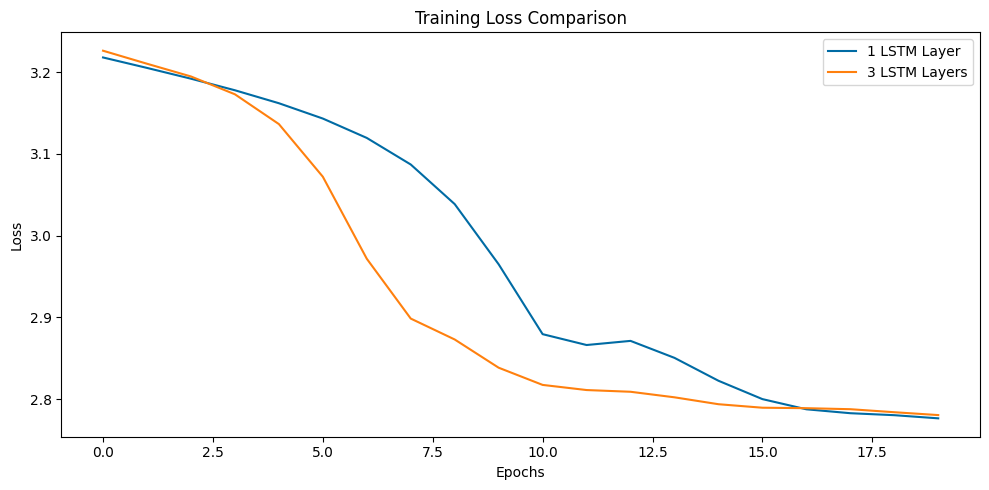

In [6]:
# Build a deeper model with 3 LSTM layers
deep_model = build_model(num_layers=3, lstm_units=128)
deep_model.summary()

# Train the deep model
history_deep = deep_model.fit(x, y, batch_size=128, epochs=20)

# Generate text using the deeper model
generated_text_deep = generate_text(deep_model, seed_text, length=300, temperature=0.5)
print("\nGenerated text with 3 LSTM layers:")
print(generated_text_deep)

# Plot training loss for both models
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='1 LSTM Layer')
plt.plot(history_deep.history['loss'], label='3 LSTM Layers')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.tight_layout()
plt.show()

## Conclusion

In this notebook, we built an LSTM-based text generator using a unique dataset of ancient myths. We explored how increasing the network depth affects text generation quality and observed the training loss curves. Feel free to experiment further by adjusting hyperparameters, using different temperature settings, or even trying word-level models.

Happy coding!